<a href="https://colab.research.google.com/github/seungyihong/mathbigdata/blob/master/Test_LSTM_ModelCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setting

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#@title 현재 경로명 입력
#@markdown /My Drive/ [ **any directory you use** ]
Directory = "Dacon/\uC628\uB3C4 \uCD94\uC815" #@param {type:"string"}

currDir = '/content/drive/My Drive/' + Directory
#현재 코드가 실행되는 디렉토리명
print("현재 경로:", currDir)

현재 경로: /content/drive/My Drive/Dacon/온도 추정
현재 경로: /content/drive/My Drive/Dacon/온도 추정


In [0]:
#!pip install tensorflow-gpu==2.1.0

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import random
import tensorflow as tf
import os
import pickle
import warnings 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from matplotlib import style; style.use('ggplot')
import multiprocessing
from sklearn.feature_selection import VarianceThreshold # 특성 공학
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import Ridge, Lasso, LinearRegression, BayesianRidge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
import lightgbm as lgb
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
%matplotlib inline
print(tf.__version__)
print(tf.test.is_gpu_available()); print('-'*50)

np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)
print('Random seed set'); print('-'*50)

train = pd.read_csv(currDir + '/input/train.csv', index_col = 'id')
test = pd.read_csv(currDir + '/input/test.csv', index_col = 'id')
print('Data: train / test set'); print('-'*50)

# 데이터 정보
temperature_name = ["X00","X07","X28","X31","X32"] #기온
localpress_name  = ["X01","X06","X22","X27","X29"] #현지기압
speed_name       = ["X02","X03","X18","X24","X26"] #풍속
water_name       = ["X04","X10","X21","X36","X39"] #일일 누적강수량
press_name       = ["X05","X08","X09","X23","X33"] #해면기압
sun_name         = ["X11","X14","X16","X19","X34"] #일일 누적일사량
humidity_name    = ["X12","X20","X30","X37","X38"] #습도
direction_name   = ["X13","X15","X17","X25","X35"] #풍향

press_sum_name   = ["X01","X06","X22","X27","X29","X05","X08","X09","X23","X33"]

2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


True
--------------------------------------------------
Random seed set
--------------------------------------------------
Data: train / test set
--------------------------------------------------
2.1.0
True
--------------------------------------------------
Random seed set
--------------------------------------------------
Data: train / test set
--------------------------------------------------


In [0]:
def Scaler(X_train_, X_test_, mode='minmax'):
  '''
  Standard 또는 Minmax Sclaer 적용
  '''
  if mode == 'standard':
    MEAN = X_train.mean()
    STD  = X_train.std()
    X_train_ = (X_train_ - MEAN) / (STD + 1e-07)
    X_test_  = (X_test_  - MEAN) / (STD + 1e-07)
    print('standard scaling complete...'); print('-'*50)

  elif mode == 'minmax':
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    for col_ in X_train_.columns:
      train_scaled = scaler.fit_transform(X_train_[col_][:, np.newaxis])
      test_scaled = scaler.transform(X_test_[col_][:, np.newaxis])
      X_train_[col_] = train_scaled.flatten()
      X_test_[col_] = test_scaled.flatten()
    print('minmax scaling complete...'); print('-'*50)
  print('X_train:\n',X_train_.head()); print('-'*50)
  print('X_test:\n',X_test_.head()); print('-'*50)

  return X_train_, X_test_

def convert_to_timeseries(df, interval):
  '''
  RNN 모델에 입력 할 수 있는 시계열 형태로 데이터 변환 
  '''
  sequence_list = []
  target_list = []

  for i in tqdm(range(df.shape[0] - interval)):
    sequence_list.append(np.array(df.iloc[i:i+interval,:-1]))
    target_list.append(df.iloc[i+interval,-1])

  sequence = np.array(sequence_list)
  target = np.array(target_list)

  return sequence, target

def Make_Xy_ts(y_columns_, X_train_, y_train_):
  sequence = np.empty((0,12,len(X_train_norm.columns)))
  target = np.empty((0,))

  for column in y_columns_:

    concat = pd.concat([X_train_, y_train_[column]], axis =1) #train[column]

    _sequence, _target = convert_to_timeseries(concat.head(144*30), interval = 12)
    # 24시간 = 1440분 = 144* 10분 즉, 30일 

    sequence = np.vstack((sequence, _sequence))
    target = np.hstack((target,_target))
  
  return sequence, target

def mse_keras(y_true, y_pred):
  '''
  custom metric 정의
  '''
  def mse_AIFrenz(y_true, y_pred):
    diff = abs(y_true - y_pred)
    less_then_one = np.where(diff < 1, 0, diff)
    # multi-column일 경우에도 계산 할 수 있도록 np.average를 한번 더 씌움
    try:
        score = np.average(np.average(less_then_one ** 2, axis = 0))
    except ValueError:
        score = mean_squared_error(y_true, y_pred)
    return score

  score = tf.py_function(func=mse_AIFrenz, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') # tf 2.x
  return score

def build_model(lr):
  '''
  간단한 lstm 모델 구축하기
  '''
  lstm_model = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(128, input_shape=sequence.shape[-2:]),
      tf.keras.layers.Dense(256, activation='linear'),
      tf.keras.layers.Dense(128, activation='linear'),
      tf.keras.layers.Dense(1)
  ])
  
  # opt = tf.keras.optimizers.RMSprop(lr)
  opt = tf.keras.optimizers.Adam(lr)
  # opt = tf.keras.optimizers.Nadam(lr)
  
  lstm_model.compile(optimizer=opt, loss='mse', metrics=[mse_keras])

  return lstm_model

# 전이 학습을 위해 느슨한 학습을 적용
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if(logs.get('loss') < 3):
            print('\n Loss is under 3, cancelling training')
            self.model.stop_training = True

## 여기 수정하면서 실험

In [0]:
'''사용할 피쳐 정의해서 사용'''
SELECT_TEMP_COL_LIST  = ['X00', 'X31', 'X32']
SELECT_HUMID_COL_LIST = ['X30', 'X37', 'X38']
SELECT_SUN_COL_LIST   = ['X11']
TEST_COL_LIST         = ["X29","X27"]
USE_COL_LIST          = SELECT_TEMP_COL_LIST + SELECT_HUMID_COL_LIST + SELECT_SUN_COL_LIST 
print(USE_COL_LIST)

X_train = train.loc[:, USE_COL_LIST].copy()
X_test = test.loc[:, USE_COL_LIST].copy()

['X00', 'X31', 'X32', 'X30', 'X37', 'X38', 'X11']
['X00', 'X31', 'X32', 'X30', 'X37', 'X38', 'X11']


In [0]:
'''SELECT_TEMP_COL_LIST를 이용한 TRAIN_TEMP_MEAN , TEST_TEMP_MEAN 생성'''
TRAIN_TEMP_MEAN = X_train[SELECT_TEMP_COL_LIST].mean(axis=1)
TEST_TEMP_MEAN  = X_test[SELECT_TEMP_COL_LIST].mean(axis=1)

'''스케일링 처리'''
X_train_norm, X_test_norm = Scaler(X_train, X_test, mode='standard')
# X_train_norm, X_test_norm = Scaler(X_train, X_test, mode='minmax')

'''t시점 이전 120분의 데이터로 t시점의 온도를 추정할 수 있는 학습데이터 형성'''
y_columns = ['Y15','Y16']
sequence, target = Make_Xy_ts(y_columns, X_train_norm, train)

'''X_test_ts 생성'''
X_train_norm['dummy'] = 0; X_test_norm['dummy'] = 0
X_test_ts, _ = convert_to_timeseries(pd.concat([X_train_norm,X_test_norm],axis = 0 ), interval = 12)
X_test_ts = X_test_ts[-11520:,:,:]
X_train_norm.drop('dummy',axis=1, inplace = True); X_test_norm.drop('dummy', axis = 1 ,inplace=True)

standard scaling complete...
--------------------------------------------------
X_train:
          X00       X31       X32       X30       X37       X38      X11
id                                                                     
0  -2.236377 -2.109779 -1.766623  0.159919  0.577720  0.240703 -1.01241
1  -2.321347 -2.091664 -1.842501  0.215666  0.582841  0.289700 -1.01241
2  -2.300105 -2.146009 -1.956318  0.271413  0.582841  0.311477 -1.01241
3  -2.300105 -2.200355 -2.013226  0.350389  0.593083  0.344142 -1.01241
4  -2.342589 -2.254700 -2.013226  0.401490  0.618688  0.371363 -1.01241
--------------------------------------------------
X_test:
 

  5%|▌         | 231/4308 [00:00<00:01, 2306.19it/s]

           X00       X31       X32       X30       X37       X38      X11
id                                                                       
4752 -0.324563 -0.425076 -0.154219  1.195890  0.925952  0.093710 -1.01241
4753 -0.303321 -0.443191 -0.173188  1.205181  0.925952  0.126375 -1.01241
4754 -0.260836 -0.479421 -0.192158  1.223763  0.977163  0.142708 -1.01241
4755 -0.324563 -0.479421 -0.230097  1.270219  1.018131  0.164484 -1.01241
4756 -0.388290 -0.443191 -0.211127  1.237700  1.094947  0.191705 -1.01241
--------------------------------------------------


  5%|▍         | 198/4308 [00:00<00:02, 1972.09it/s]

standard scaling complete...
--------------------------------------------------
X_train:
          X00       X31       X32       X30       X37       X38      X11
id                                                                     
0  -2.236377 -2.109779 -1.766623  0.159919  0.577720  0.240703 -1.01241
1  -2.321347 -2.091664 -1.842501  0.215666  0.582841  0.289700 -1.01241
2  -2.300105 -2.146009 -1.956318  0.271413  0.582841  0.311477 -1.01241
3  -2.300105 -2.200355 -2.013226  0.350389  0.593083  0.344142 -1.01241
4  -2.342589 -2.254700 -2.013226  0.401490  0.618688  0.371363 -1.01241
--------------------------------------------------
X_test:
            X00       X31       X32       X30       X37       X38      X11
id                                                                       
4752 -0.324563 -0.425076 -0.154219  1.195890  0.925952  0.093710 -1.01241
4753 -0.303321 -0.443191 -0.173188  1.205181  0.925952  0.126375 -1.01241
4754 -0.260836 -0.479421 -0.192158  1.223763  0.97

 62%|██████▏   | 10030/16260 [00:05<00:03, 1843.67it/s]

In [0]:
'''모델 빌드'''
LEARNINGRATE = 0.001
lstm_model = build_model(LEARNINGRATE)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 135,681
Trainable params: 135,681
Non-trainable params: 0
_________________________________________________________________


In [0]:
'''1차 피팅'''
callbacks = myCallback()

lstm_model.fit(    
    sequence, target, # X_train_T, y_train_T, #
    epochs = 100,
    batch_size = 128,
    verbose = 2,
    shuffle = False,
    #callbacks = [callbacks],
    workers = multiprocessing.cpu_count(),
    use_multiprocessing = True
)

Train on 8616 samples
Epoch 1/100
8616/8616 - 3s - loss: 135.2673 - mse_keras: 134.2067
Epoch 2/100
8616/8616 - 0s - loss: 9.1945 - mse_keras: 9.0296
Epoch 3/100
8616/8616 - 0s - loss: 6.7587 - mse_keras: 6.6115
Epoch 4/100
8616/8616 - 0s - loss: 6.4895 - mse_keras: 6.3397
Epoch 5/100
8616/8616 - 0s - loss: 6.2097 - mse_keras: 6.0595
Epoch 6/100
8616/8616 - 0s - loss: 5.9344 - mse_keras: 5.7763
Epoch 7/100
8616/8616 - 0s - loss: 5.7595 - mse_keras: 5.5992
Epoch 8/100
8616/8616 - 0s - loss: 5.6830 - mse_keras: 5.5229
Epoch 9/100
8616/8616 - 0s - loss: 5.5549 - mse_keras: 5.3956
Epoch 10/100
8616/8616 - 0s - loss: 5.3202 - mse_keras: 5.1626
Epoch 11/100
8616/8616 - 0s - loss: 5.0921 - mse_keras: 4.9372
Epoch 12/100
8616/8616 - 0s - loss: 4.9132 - mse_keras: 4.7576
Epoch 13/100
8616/8616 - 0s - loss: 4.7724 - mse_keras: 4.6168
Epoch 14/100
8616/8616 - 0s - loss: 4.6560 - mse_keras: 4.4988
Epoch 15/100
8616/8616 - 0s - loss: 4.5534 - mse_keras: 4.3956
Epoch 16/100
8616/8616 - 0s - loss: 4.

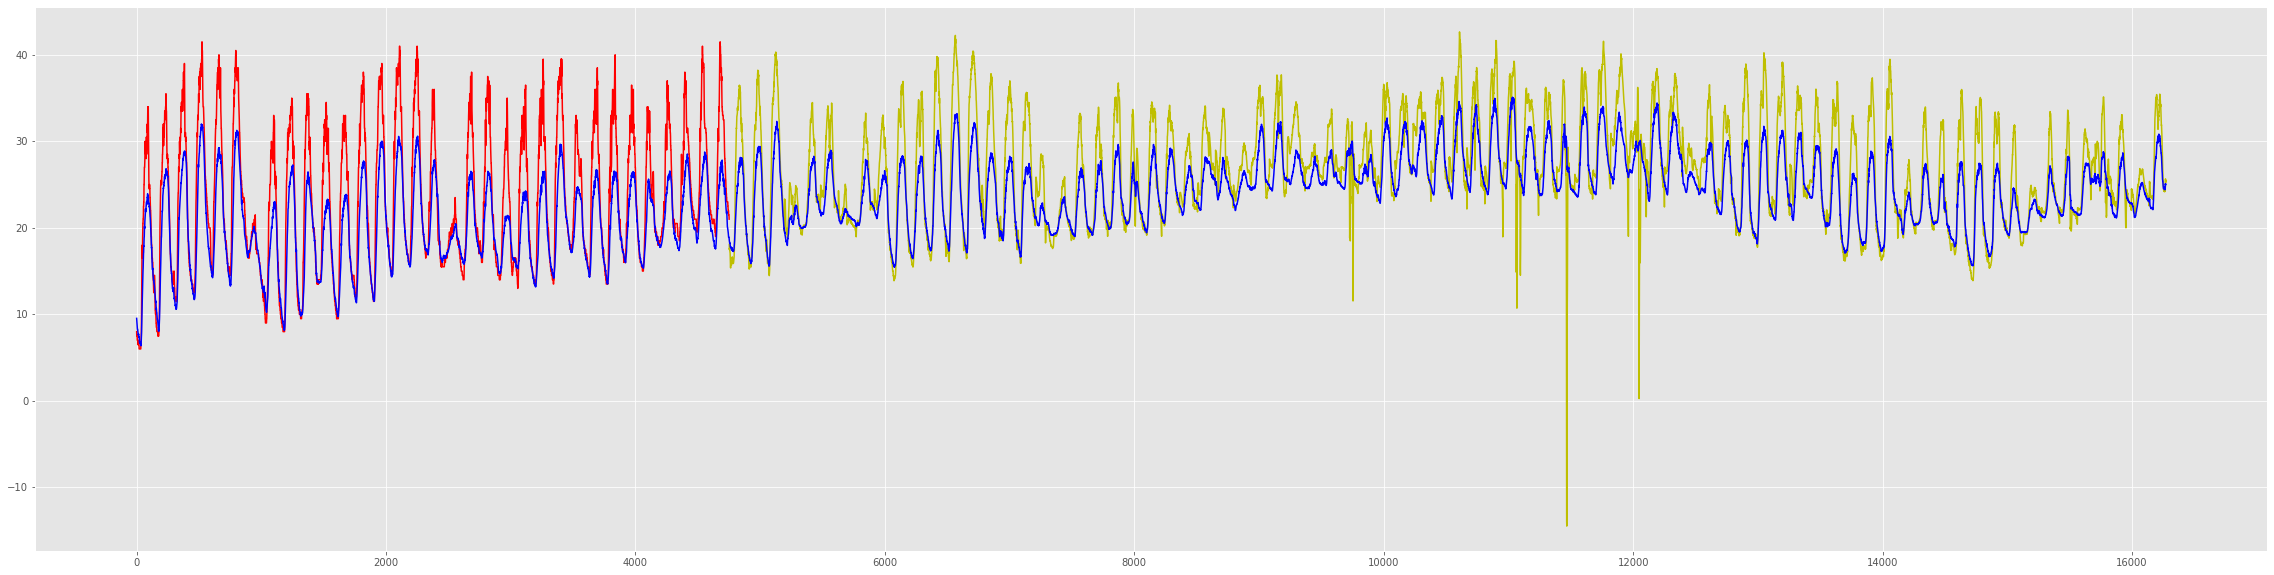

In [0]:
# 예측하기
finetune_pred = lstm_model.predict(X_test_ts)

'''플롯'''
ff=finetune_pred.flatten()
style.use('ggplot')
t3 = np.arange(4752,16272,1)
temp_all = pd.concat([TRAIN_TEMP_MEAN, TEST_TEMP_MEAN], axis =0)
now = pd.concat([train.loc[:4320,'Y16'],train.loc[4320:4752,'Y18']],axis =0)

# red - y16(30) + y18(3), yellow - 예측, blue - X temp 데이터
plt.figure(figsize = (40,10))
plt.plot(now,'r')
plt.plot(t3,ff, 'y')
plt.plot(temp_all,'b')

In [0]:
# LSTM 레이어는 고정
lstm_model.layers[0].trainalbe = False

# fine tuning 할 때 사용할 학습데이터 생성 (Y18)
finetune_X, finetune_y = convert_to_timeseries(pd.concat([X_train_norm.tail(432), train['Y18'].tail(432)],axis = 1),interval = 12)

'''2차 피팅'''
finetune_history = lstm_model.fit(
            finetune_X, finetune_y,
            epochs = 100,
            batch_size = 256,
            shuffle = False,
            verbose = 2,
            workers = multiprocessing.cpu_count(),
            use_multiprocessing = True)#,
            #callbacks = callbacks2)

100%|██████████| 420/420 [00:00<00:00, 1141.43it/s]


Train on 420 samples
Epoch 1/100
420/420 - 0s - loss: 10.1127 - mse_keras: 9.7980
Epoch 2/100
420/420 - 0s - loss: 7.0786 - mse_keras: 6.4050
Epoch 3/100
420/420 - 0s - loss: 6.0776 - mse_keras: 5.3346
Epoch 4/100
420/420 - 0s - loss: 5.0124 - mse_keras: 4.4250
Epoch 5/100
420/420 - 0s - loss: 3.7390 - mse_keras: 3.5255
Epoch 6/100
420/420 - 0s - loss: 3.2421 - mse_keras: 3.2279
Epoch 7/100
420/420 - 0s - loss: 2.6053 - mse_keras: 2.5082
Epoch 8/100
420/420 - 0s - loss: 2.3333 - mse_keras: 2.0714
Epoch 9/100
420/420 - 0s - loss: 2.6000 - mse_keras: 2.2929
Epoch 10/100
420/420 - 0s - loss: 2.4683 - mse_keras: 2.2199
Epoch 11/100
420/420 - 0s - loss: 2.2402 - mse_keras: 2.1007
Epoch 12/100
420/420 - 0s - loss: 2.0784 - mse_keras: 1.9544
Epoch 13/100
420/420 - 0s - loss: 1.8597 - mse_keras: 1.7059
Epoch 14/100
420/420 - 0s - loss: 1.9263 - mse_keras: 1.7148
Epoch 15/100
420/420 - 0s - loss: 1.9296 - mse_keras: 1.7452
Epoch 16/100
420/420 - 0s - loss: 1.7637 - mse_keras: 1.6736
Epoch 17/10

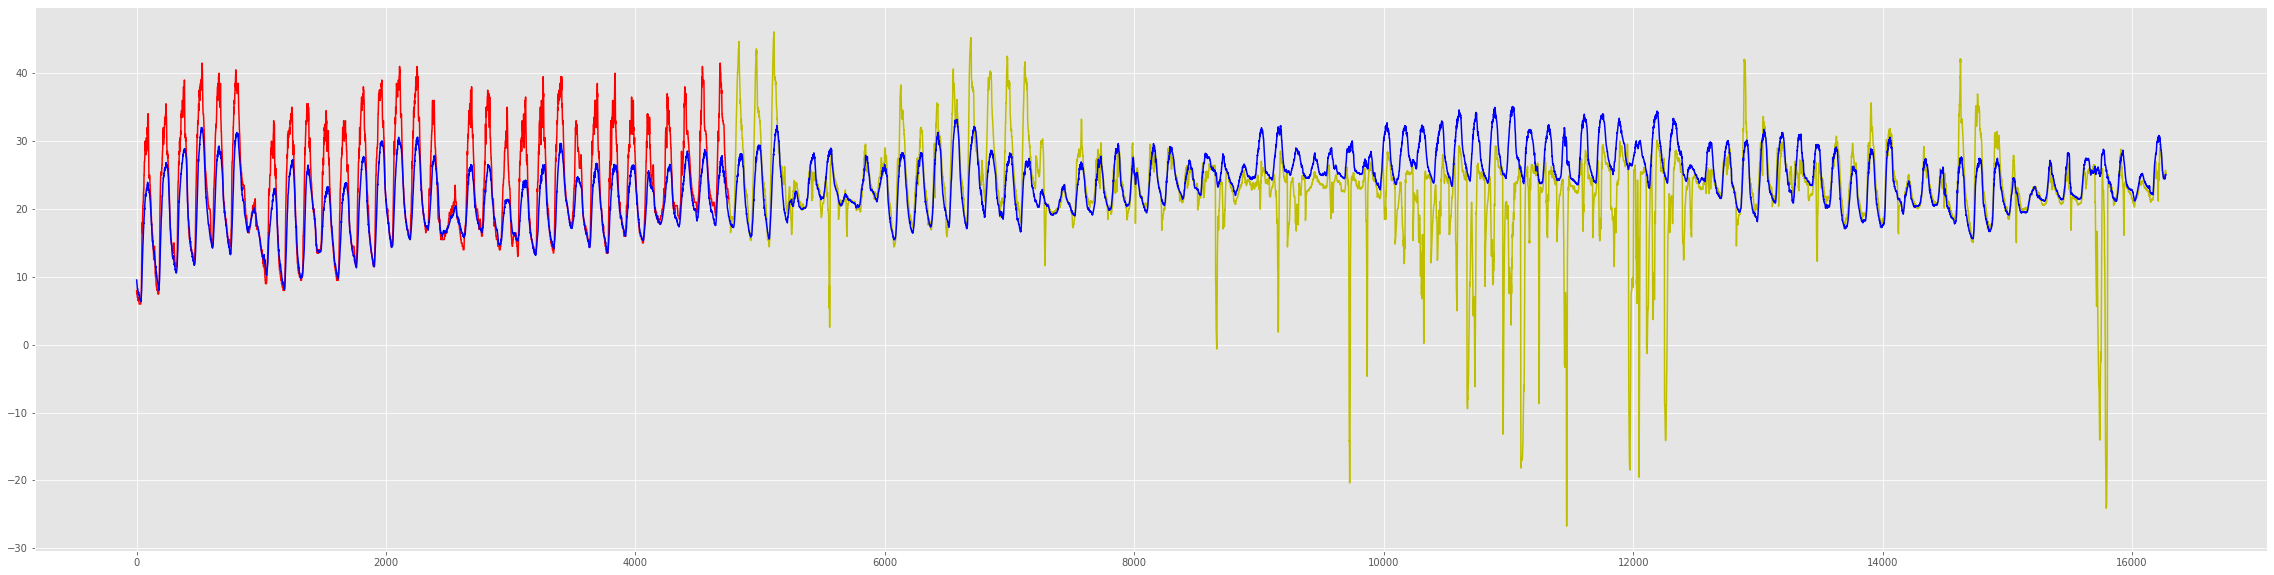

In [0]:
# 예측하기
finetune_pred = lstm_model.predict(X_test_ts)

'''플롯'''
ff=finetune_pred.flatten()
style.use('ggplot')
t3 = np.arange(4752,16272,1)
temp_all = pd.concat([TRAIN_TEMP_MEAN, TEST_TEMP_MEAN], axis =0)
now = pd.concat([train.loc[:4320,'Y16'],train.loc[4320:4752,'Y18']],axis =0)

# red - y16(30) + y18(3), yellow - 예측, blue - X temp 데이터
plt.figure(figsize = (40,10))
plt.plot(now,'r')
plt.plot(t3,ff, 'y')
plt.plot(temp_all,'b')

In [0]:
# # 제출 파일 만들기
# submit = pd.DataFrame({'id':range(144*33, 144*113),
#               'Y18':finetune_pred.reshape(1,-1)[0]})
# submit.to_csv(currDir + '/submit/test_temp3_hum3_sun1_speed4(X0203).csv', index = False)